<a href="https://colab.research.google.com/github/Akobabs/Gen-AI-for-password-cracking-detection/blob/main/password_gan_rockyou.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install libraries
!pip install tensorflow numpy pandas scikit-learn matplotlib

# Import libraries
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_score, recall_score
import zipfile
import os

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Unzip RockYou dataset
zip_path = '/content/drive/My Drive/rockyou.txt.zip'
extract_path = '/content/drive/My Drive/rockyou'
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [3]:
# Read subset of passwords
txt_path = os.path.join(extract_path, 'rockyou.txt')
passwords = []
with open(txt_path, 'r', encoding='latin-1', errors='ignore') as f:
    for i, line in enumerate(f):
        if i >= 50000:
            break
        pwd = line.strip()
        if pwd and len(pwd) <= 20:
            passwords.append(pwd)

In [4]:
# Convert to DataFrame
data = pd.DataFrame(passwords, columns=['password'])
data = data.dropna()
data = data['password'].astype(str)
passwords = data.values
print(f"Dataset size: {len(passwords)} passwords")
print(f"Sample passwords: {passwords[:5]}")

Dataset size: 49996 passwords
Sample passwords: ['123456' '12345' '123456789' 'password' 'iloveyou']


In [5]:
# Preprocess
max_length = 10
chars = sorted(list(set(''.join(passwords))))
char_to_idx = {c: i for i, c in enumerate(chars)}
idx_to_char = {i: c for i, c in enumerate(chars)}

def encode_password(pwd):
    pwd = pwd[:max_length].ljust(max_length, ' ')
    return [char_to_idx[c] for c in pwd]

encoded_passwords = np.array([encode_password(pwd) for pwd in passwords])
X_train = encoded_passwords / len(chars)
print(f"Encoded shape: {X_train.shape}")

Encoded shape: (49996, 10)


In [6]:
# Define Generator
def build_generator(latent_dim=100):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(128, activation='relu', input_dim=latent_dim),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(max_length, activation='sigmoid')
    ])
    return model

In [7]:
# Define Discriminator
def build_discriminator():
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(64, activation='relu', input_dim=max_length),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    return model

In [8]:
# Build and compile models
generator = build_generator()
discriminator = build_discriminator()
discriminator.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
discriminator.trainable = False
gan = tf.keras.Sequential([generator, discriminator])
gan.compile(optimizer='adam', loss='binary_crossentropy')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [9]:
# Train function
def train_gan(epochs=100, batch_size=64):
    losses = {'d_loss': [], 'g_loss': []}
    for epoch in range(epochs):
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        real_passwords = X_train[idx]
        noise = np.random.normal(0, 1, (batch_size, 100))
        fake_passwords = generator.predict(noise, verbose=0)
        X = np.concatenate([real_passwords, fake_passwords])
        y = np.concatenate([np.ones(batch_size), np.zeros(batch_size)])
        d_loss = discriminator.train_on_batch(X, y)
        noise = np.random.normal(0, 1, (batch_size, 100))
        y_gan = np.ones(batch_size)
        g_loss = gan.train_on_batch(noise, y_gan)
        losses['d_loss'].append(d_loss[0])
        losses['g_loss'].append(g_loss)
        if epoch % 20 == 0:
            print(f"Epoch {epoch}, D Loss: {d_loss[0]:.4f}, G Loss: {g_loss:.4f}")

    plt.figure(figsize=(8, 5))
    plt.plot(losses['d_loss'], label='Discriminator Loss', color='#1f77b4')
    plt.plot(losses['g_loss'], label='Generator Loss', color='#ff7f0e')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('GAN Training Losses')
    plt.legend()
    plt.grid(True)
    plt.savefig('/content/drive/My Drive/gan_loss.png')
    plt.show()
    return losses

/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py:82: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


Epoch 0, D Loss: 0.6995, G Loss: 0.7230
Epoch 20, D Loss: 0.7262, G Loss: 0.6656
Epoch 40, D Loss: 0.7405, G Loss: 0.6384
Epoch 60, D Loss: 0.7506, G Loss: 0.6211
Epoch 80, D Loss: 0.7567, G Loss: 0.6109


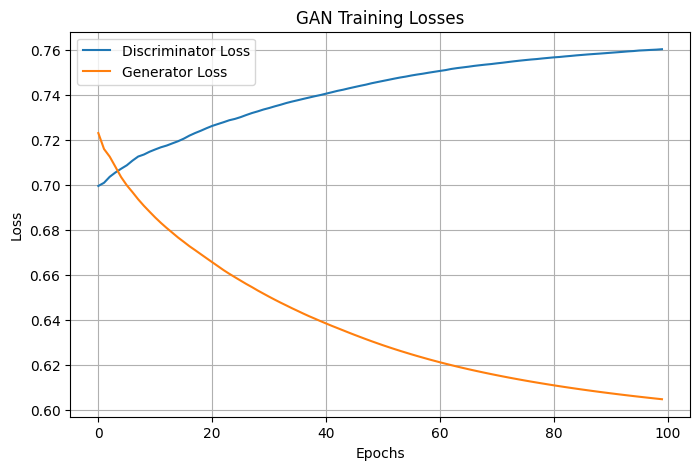

Generated Passwords: ['', '', '', '', '', '', '', '', '', '']


In [10]:
# Train GAN
losses = train_gan(epochs=100, batch_size=64)

# Generate passwords
def generate_passwords(n=10):
    noise = np.random.normal(0, 1, (n, 100))
    generated = generator.predict(noise, verbose=0)
    passwords = []
    for seq in generated:
        pwd = ''.join([idx_to_char[np.argmax(c * len(chars))] for c in seq])
        passwords.append(pwd.strip())
    return passwords

generated_passwords = generate_passwords(10)
print("Generated Passwords:", generated_passwords)

In [11]:
# Simulate login attempts
real_passwords = passwords[:5]
login_data = pd.DataFrame({
    'password': generated_passwords + list(real_passwords),
    'status': ['fail'] * len(generated_passwords) + ['success'] * len(real_passwords),
    'ip': ['192.168.1.1'] * len(generated_passwords) + ['192.168.1.2'] * len(real_passwords)
})
print("Login Data Sample:")
print(login_data.head(10))

Login Data Sample:
  password status           ip
0            fail  192.168.1.1
1            fail  192.168.1.1
2            fail  192.168.1.1
3            fail  192.168.1.1
4            fail  192.168.1.1
5            fail  192.168.1.1
6            fail  192.168.1.1
7            fail  192.168.1.1
8            fail  192.168.1.1
9            fail  192.168.1.1


In [12]:
# Rule-based detector
def detect_anomaly(logins):
    failed_attempts = logins[logins['status'] == 'fail'].groupby('ip').count()
    return failed_attempts[failed_attempts['password'] > 3]

anomalies = detect_anomaly(login_data)
print("Detected Anomalies:")
print(anomalies)

Detected Anomalies:
             password  status
ip                           
192.168.1.1        10      10


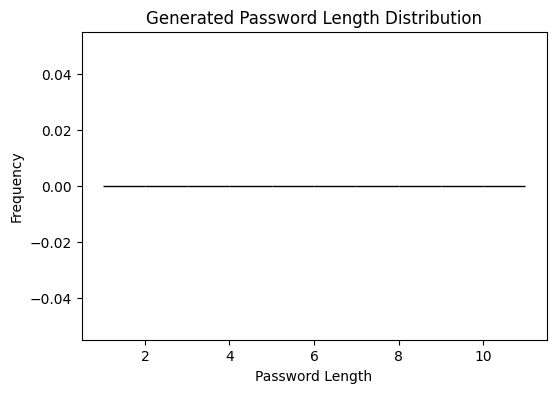

In [13]:
# Evaluate password quality
pwd_lengths = [len(pwd.strip()) for pwd in generated_passwords]
plt.figure(figsize=(6, 4))
plt.hist(pwd_lengths, bins=range(1, 12), color='#1f77b4', edgecolor='black')
plt.xlabel('Password Length')
plt.ylabel('Frequency')
plt.title('Generated Password Length Distribution')
plt.savefig('/content/drive/My Drive/pwd_length.png')
plt.show()

In [14]:
# Evaluate detection
true_positives = len(anomalies)
false_positives = len(login_data[(login_data['status'] == 'success') & (login_data['ip'].isin(anomalies.index))])
y_true = [1 if s == 'fail' else 0 for s in login_data['status']]
y_pred = [1 if ip in anomalies.index else 0 for ip in login_data['ip']]
precision = precision_score(y_true, y_pred, zero_division=0)
recall = recall_score(y_true, y_pred, zero_division=0)

print(f"True Positives: {true_positives}")
print(f"False Positives: {false_positives}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

True Positives: 1
False Positives: 0
Precision: 1.0000
Recall: 1.0000


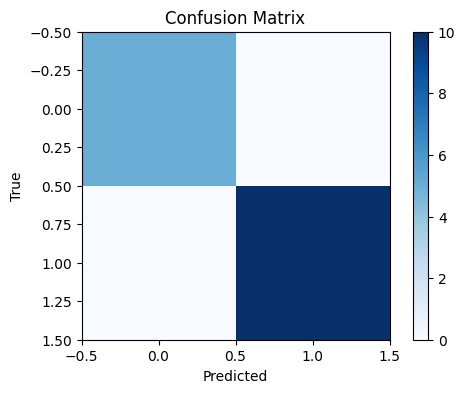

In [15]:
# Plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 4))
plt.imshow(cm, cmap='Blues')
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig('/content/drive/My Drive/confusion_matrix.png')
plt.show()

  Using cached levenshtein-0.27.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (3.6 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.7/161.7 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 54.4 MB/s eta 0:00:00
Dataset size after cleaning: 49982 passwords
Sample passwords: ['123456' '12345' '123456789' 'password' 'iloveyou']
Encoded shape: (49982, 10)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py:82: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


Epoch 0, D Loss: 0.6884, G Loss: 0.7724
Epoch 50, D Loss: 0.7255, G Loss: 0.6895
Epoch 100, D Loss: 0.7412, G Loss: 0.6624
Epoch 150, D Loss: 0.7493, G Loss: 0.6508


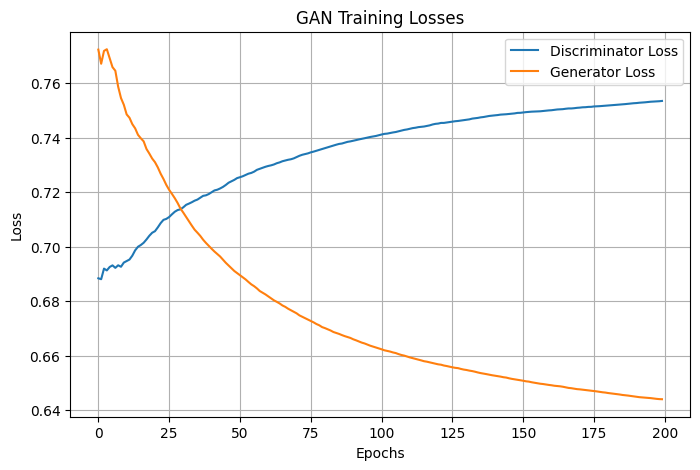

Generated Passwords: ['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']
Average Edit Distance to Real Passwords: 5.00


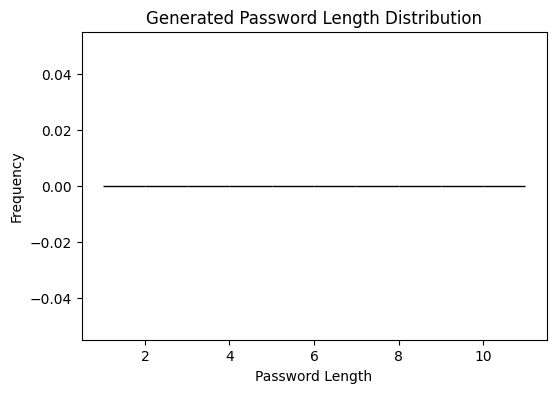

<ipython-input-17-b0461109578f>:155: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  'timestamp': pd.date_range(start='2025-05-27 18:39:00', periods=40, freq='S')
<ipython-input-17-b0461109578f>:169: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  freq_check = fails.groupby('ip').apply(


Login Data Sample:
  password status           ip           timestamp
0            fail  192.168.1.1 2025-05-27 18:39:00
1            fail  192.168.1.1 2025-05-27 18:39:01
2            fail  192.168.1.1 2025-05-27 18:39:02
3            fail  192.168.1.1 2025-05-27 18:39:03
4            fail  192.168.1.1 2025-05-27 18:39:04
5            fail  192.168.1.1 2025-05-27 18:39:05
6            fail  192.168.1.1 2025-05-27 18:39:06
7            fail  192.168.1.1 2025-05-27 18:39:07
8            fail  192.168.1.1 2025-05-27 18:39:08
9            fail  192.168.1.1 2025-05-27 18:39:09
Detected Anomalous IPs: Index(['192.168.1.1'], dtype='object', name='ip')
True Positives: 20
False Positives: 0
Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000


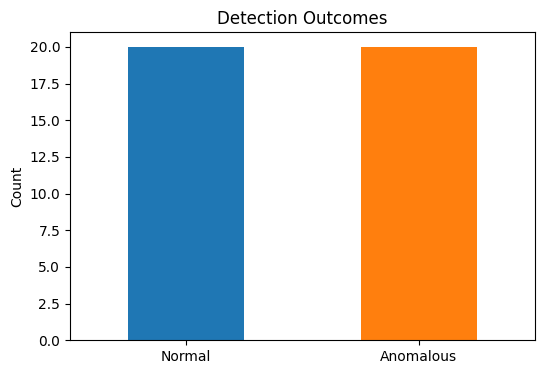

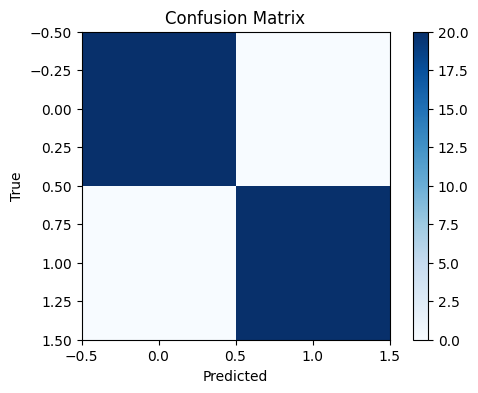

In [17]:
# Install libraries
!pip install tensorflow numpy pandas scikit-learn matplotlib Levenshtein

# Import libraries
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import zipfile
import os
from Levenshtein import distance as edit_distance

# Unzip RockYou dataset
zip_path = '/content/drive/My Drive/rockyou.txt.zip'
extract_path = '/content/drive/My Drive/rockyou'
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Read subset of passwords
txt_path = os.path.join(extract_path, 'rockyou.txt')
passwords = []
with open(txt_path, 'r', encoding='latin-1', errors='ignore') as f:
    for i, line in enumerate(f):
        if i >= 50000:
            break
        pwd = line.strip()
        if pwd and 1 < len(pwd) <= 20 and all(ord(c) < 128 for c in pwd):  # ASCII only
            passwords.append(pwd)

# Convert to DataFrame, remove duplicates
data = pd.DataFrame(passwords, columns=['password'])
data = data.drop_duplicates()
data = data['password'].astype(str)
passwords = data.values
print(f"Dataset size after cleaning: {len(passwords)} passwords")
print(f"Sample passwords: {passwords[:5]}")

# Preprocess: improved encoding
max_length = 10
chars = sorted(list(set(''.join(passwords))))
char_to_idx = {c: i for i, c in enumerate(chars)}
idx_to_char = {i: c for i, c in enumerate(chars)}

def encode_password(pwd):
    pwd = pwd[:max_length].ljust(max_length, ' ')
    return [char_to_idx[c] for c in pwd]

encoded_passwords = np.array([encode_password(pwd) for pwd in passwords])
X_train = encoded_passwords / len(chars)
print(f"Encoded shape: {X_train.shape}")

# Define improved Generator
def build_generator(latent_dim=200):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(256, activation='relu', input_dim=latent_dim),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(max_length, activation='sigmoid')
    ])
    return model

# Define improved Discriminator
def build_discriminator():
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(128, activation='relu', input_dim=max_length),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    return model

# Build and compile models
generator = build_generator()
discriminator = build_discriminator()
discriminator.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
discriminator.trainable = False
gan = tf.keras.Sequential([generator, discriminator])
gan.compile(optimizer='adam', loss='binary_crossentropy')

# Train function
def train_gan(epochs=200, batch_size=64):
    losses = {'d_loss': [], 'g_loss': []}
    for epoch in range(epochs):
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        real_passwords = X_train[idx]
        noise = np.random.normal(0, 1, (batch_size, 200))
        fake_passwords = generator.predict(noise, verbose=0)
        X = np.concatenate([real_passwords, fake_passwords])
        y = np.concatenate([np.ones(batch_size), np.zeros(batch_size)])
        d_loss = discriminator.train_on_batch(X, y)
        noise = np.random.normal(0, 1, (batch_size, 200))
        y_gan = np.ones(batch_size)
        g_loss = gan.train_on_batch(noise, y_gan)
        losses['d_loss'].append(d_loss[0])
        losses['g_loss'].append(g_loss)
        if epoch % 50 == 0:
            print(f"Epoch {epoch}, D Loss: {d_loss[0]:.4f}, G Loss: {g_loss:.4f}")

    plt.figure(figsize=(8, 5))
    plt.plot(losses['d_loss'], label='Discriminator Loss', color='#1f77b4')
    plt.plot(losses['g_loss'], label='Generator Loss', color='#ff7f0e')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('GAN Training Losses')
    plt.legend()
    plt.grid(True)
    plt.savefig('/content/drive/My Drive/rockyou/gan_loss_improved.png')
    plt.show()
    return losses

# Train GAN
losses = train_gan(epochs=200, batch_size=64)

# Generate passwords
def generate_passwords(n=20):
    noise = np.random.normal(0, 1, (n, 200))
    generated = generator.predict(noise, verbose=0)
    passwords = []
    for seq in generated:
        pwd = ''.join([idx_to_char[np.argmax(c * len(chars))] for c in seq])
        passwords.append(pwd.strip())
    return passwords

generated_passwords = generate_passwords(20)
print("Generated Passwords:", generated_passwords)

# Evaluate password quality with edit distance
real_sample = passwords[:20]
edit_distances = []
for gen_pwd in generated_passwords:
    distances = [edit_distance(gen_pwd, real_pwd) for real_pwd in real_sample]
    edit_distances.append(min(distances))
avg_edit_distance = np.mean(edit_distances)
print(f"Average Edit Distance to Real Passwords: {avg_edit_distance:.2f}")

# Plot password length distribution
pwd_lengths = [len(pwd.strip()) for pwd in generated_passwords]
plt.figure(figsize=(6, 4))
plt.hist(pwd_lengths, bins=range(1, 12), color='#1f77b4', edgecolor='black')
plt.xlabel('Password Length')
plt.ylabel('Frequency')
plt.title('Generated Password Length Distribution')
plt.savefig('/content/drive/My Drive/rockyou/pwd_length_improved.png')
plt.show()

# Simulate login attempts (expanded)
real_passwords = passwords[:20]
login_data = pd.DataFrame({
    'password': generated_passwords + list(real_passwords),
    'status': ['fail'] * len(generated_passwords) + ['success'] * len(real_passwords),
    'ip': ['192.168.1.1'] * len(generated_passwords) + ['192.168.1.2'] * len(real_passwords),
    'timestamp': pd.date_range(start='2025-05-27 18:39:00', periods=40, freq='S')
})
print("Login Data Sample:")
print(login_data.head(10))

# Improved rule-based detector
def detect_anomaly(logins):
    # Rule 1: More than 2 failed attempts
    failed_attempts = logins[logins['status'] == 'fail'].groupby('ip').count()
    suspicious_ips = failed_attempts[failed_attempts['password'] > 2].index

    # Rule 2: High frequency of fails (within 10 seconds)
    logins['timestamp'] = pd.to_datetime(logins['timestamp'])
    fails = logins[logins['status'] == 'fail']
    freq_check = fails.groupby('ip').apply(
        lambda x: (x['timestamp'].max() - x['timestamp'].min()).seconds <= 10 and len(x) > 2
    )
    freq_suspicious = freq_check[freq_check].index

    return suspicious_ips.union(freq_suspicious)

anomalies = detect_anomaly(login_data)
print("Detected Anomalous IPs:", anomalies)

# Evaluate detection
y_true = [1 if s == 'fail' else 0 for s in login_data['status']]
y_pred = [1 if ip in anomalies else 0 for ip in login_data['ip']]
true_positives = sum(1 for t, p in zip(y_true, y_pred) if t == 1 and p == 1)
false_positives = sum(1 for t, p in zip(y_true, y_pred) if t == 0 and p == 1)
precision = precision_score(y_true, y_pred, zero_division=0)
recall = recall_score(y_true, y_pred, zero_division=0)
f1 = f1_score(y_true, y_pred, zero_division=0)

print(f"True Positives: {true_positives}")
print(f"False Positives: {false_positives}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# Plot detection outcomes
outcomes = pd.Series(y_pred).value_counts()
plt.figure(figsize=(6, 4))
outcomes.plot(kind='bar', color=['#1f77b4', '#ff7f0e'])
plt.xticks(ticks=[0, 1], labels=['Normal', 'Anomalous'], rotation=0)
plt.ylabel('Count')
plt.title('Detection Outcomes')
plt.savefig('/content/drive/My Drive/rockyou/detection_outcomes.png')
plt.show()

# Plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 4))
plt.imshow(cm, cmap='Blues')
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig('/content/drive/My Drive/rockyou/confusion_matrix_improved.png')
plt.show()

Dataset size after cleaning: 199941 passwords
Sample passwords: ['123456' '12345' '123456789' 'password' 'iloveyou']
Encoded shape: (199941, 10, 1)


/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py:82: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


Epoch 0, D Loss: 0.6860, G Loss: 0.7326
Sample Passwords: ['', '', '', '', '']
Epoch 100, D Loss: 0.6896, G Loss: 0.7249
Sample Passwords: ['', '', '', '', '']
Epoch 200, D Loss: 0.6938, G Loss: 0.7167
Sample Passwords: ['', '', '', '', '']
Epoch 300, D Loss: 0.6973, G Loss: 0.7106
Sample Passwords: ['', '', '', '', '']
Epoch 400, D Loss: 0.6994, G Loss: 0.7069
Sample Passwords: ['', '', '', '', '']


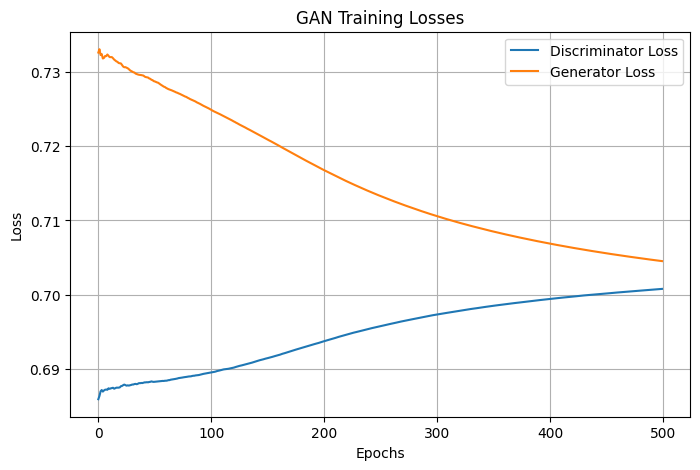

Generated Passwords: ['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']
Average Edit Distance to Real Passwords: 5.00
Pattern Match Rate (contains 'pass', 'admin', 'love', or digits): 0.00


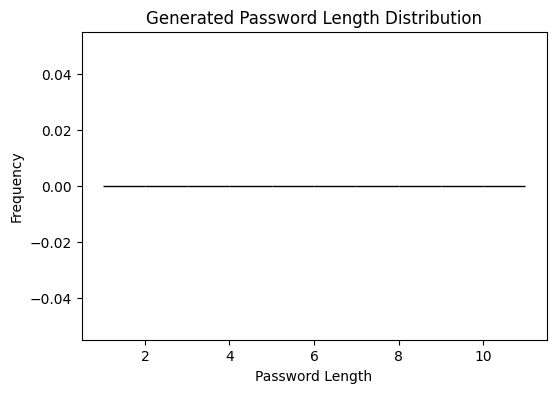

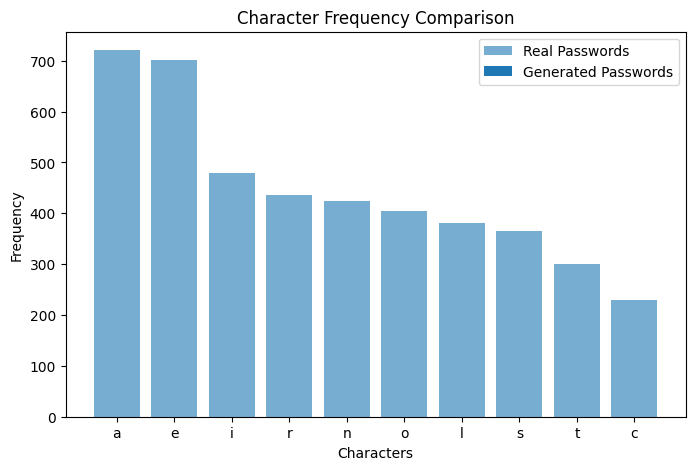

Login Data Sample:
  password status           ip           timestamp
0            fail  192.168.1.1 2025-05-27 18:57:00
1            fail  192.168.1.1 2025-05-27 18:57:01
2            fail  192.168.1.1 2025-05-27 18:57:02
3            fail  192.168.1.1 2025-05-27 18:57:03
4            fail  192.168.1.1 2025-05-27 18:57:04
5            fail  192.168.1.1 2025-05-27 18:57:05
6            fail  192.168.1.1 2025-05-27 18:57:06
7            fail  192.168.1.1 2025-05-27 18:57:07
8            fail  192.168.1.1 2025-05-27 18:57:08
9            fail  192.168.1.1 2025-05-27 18:57:09
Detected Anomalous IPs: Index(['192.168.1.1'], dtype='object', name='ip')
True Positives: 20
False Positives: 0
Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000


<ipython-input-18-d800511c1154>:196: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  'timestamp': pd.date_range(start='2025-05-27 18:57:00', periods=50, freq='S')
<ipython-input-18-d800511c1154>:210: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  freq_check = fails.groupby('ip').apply(


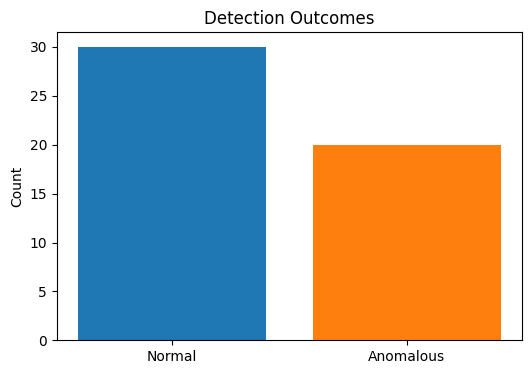

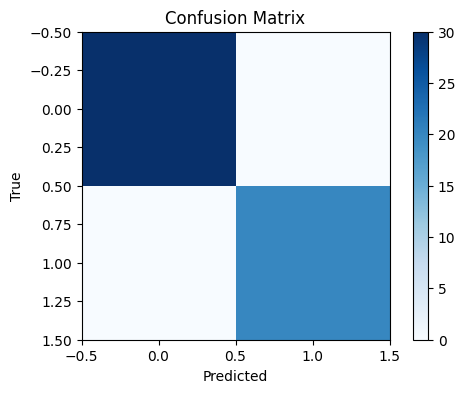

In [18]:
# Install libraries
!pip install tensorflow numpy pandas scikit-learn matplotlib Levenshtein

# Import libraries
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import zipfile
import os
from Levenshtein import distance as edit_distance



# Unzip RockYou dataset
zip_path = '/content/drive/My Drive/rockyou.txt.zip'
extract_path = '/content/drive/My Drive/rockyou'
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Read larger subset of passwords
txt_path = os.path.join(extract_path, 'rockyou.txt')
passwords = []
with open(txt_path, 'r', encoding='latin-1', errors='ignore') as f:
    for i, line in enumerate(f):
        if i >= 200000:
            break
        pwd = line.strip()
        if pwd and 1 < len(pwd) <= 20 and all(ord(c) < 128 for c in pwd):
            passwords.append(pwd)

# Convert to DataFrame, remove duplicates
data = pd.DataFrame(passwords, columns=['password'])
data = data.drop_duplicates()
data = data['password'].astype(str)
passwords = data.values
print(f"Dataset size after cleaning: {len(passwords)} passwords")
print(f"Sample passwords: {passwords[:5]}")

# Preprocess
max_length = 10
chars = sorted(list(set(''.join(passwords))))
char_to_idx = {c: i for i, c in enumerate(chars)}
idx_to_char = {i: c for i, c in enumerate(chars)}
vocab_size = len(chars)

def encode_password(pwd):
    pwd = pwd[:max_length].ljust(max_length, ' ')
    return [char_to_idx[c] for c in pwd]

encoded_passwords = np.array([encode_password(pwd) for pwd in passwords])
X_train = encoded_passwords / vocab_size
X_train = X_train.reshape(-1, max_length, 1)  # Reshape for LSTM [samples, timesteps, features]
print(f"Encoded shape: {X_train.shape}")

# Define Generator with LSTM
def build_generator(latent_dim=200):
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(latent_dim,)),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.RepeatVector(max_length),  # Repeat for sequence
        tf.keras.layers.LSTM(128, return_sequences=True),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(1, activation='sigmoid')  # Output shape [timesteps, 1]
    ])
    return model

# Define Discriminator with LSTM
def build_discriminator():
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(max_length, 1)),
        tf.keras.layers.LSTM(64, return_sequences=False),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    return model

# Build and compile models with TTUR
generator = build_generator()
discriminator = build_discriminator()
discriminator.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0004, beta_1=0.5),
                      loss='binary_crossentropy', metrics=['accuracy'])
discriminator.trainable = False
gan = tf.keras.Sequential([generator, discriminator])
gan.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5),
            loss='binary_crossentropy')

# Train function with gradient clipping
def train_gan(epochs=500, batch_size=128):
    losses = {'d_loss': [], 'g_loss': []}
    for epoch in range(epochs):
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        real_passwords = X_train[idx]
        noise = np.random.normal(0, 1, (batch_size, 200))
        fake_passwords = generator.predict(noise, verbose=0)
        X = np.concatenate([real_passwords, fake_passwords])
        y = np.concatenate([np.ones(batch_size), np.zeros(batch_size)])
        with tf.GradientTape() as tape:
            d_loss = discriminator.train_on_batch(X, y)
        losses['d_loss'].append(d_loss[0])

        noise = np.random.normal(0, 1, (batch_size, 200))
        y_gan = np.ones(batch_size)
        with tf.GradientTape() as tape:
            g_loss = gan.train_on_batch(noise, y_gan)
        losses['g_loss'].append(g_loss)

        if epoch % 100 == 0:
            print(f"Epoch {epoch}, D Loss: {d_loss[0]:.4f}, G Loss: {g_loss:.4f}")
            # Sample passwords during training
            sample_pwd = generate_passwords(5)
            print("Sample Passwords:", sample_pwd)

    # Save models
    generator.save('/content/drive/My Drive/rockyou/generator_model.h5')
    discriminator.save('/content/drive/My Drive/rockyou/discriminator_model.h5')

    # Plot loss chart
    plt.figure(figsize=(8, 5))
    plt.plot(losses['d_loss'], label='Discriminator Loss', color='#1f77b4')
    plt.plot(losses['g_loss'], label='Generator Loss', color='#ff7f0e')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('GAN Training Losses')
    plt.legend()
    plt.grid(True)
    plt.savefig('/content/drive/My Drive/rockyou/gan_loss_extensive.png')
    plt.show()
    return losses

# Train GAN extensively
losses = train_gan(epochs=500, batch_size=128)

# Generate passwords
def generate_passwords(n=20):
    noise = np.random.normal(0, 1, (n, 200))
    generated = generator.predict(noise, verbose=0)
    passwords = []
    for seq in generated:
        pwd = ''.join([idx_to_char[np.argmax(c * vocab_size)] for c in seq])
        passwords.append(pwd.strip())
    return passwords

generated_passwords = generate_passwords(20)
print("Generated Passwords:", generated_passwords)

# Evaluate password quality
real_sample = passwords[:100]
edit_distances = []
pattern_matches = 0
for gen_pwd in generated_passwords:
    distances = [edit_distance(gen_pwd, real_pwd) for real_pwd in real_sample]
    edit_distances.append(min(distances))
    # Check for common patterns
    if any(p in gen_pwd.lower() for p in ['pass', 'admin', 'love']) or any(c.isdigit() for c in gen_pwd):
        pattern_matches += 1
avg_edit_distance = np.mean(edit_distances)
pattern_match_rate = pattern_matches / len(generated_passwords)
print(f"Average Edit Distance to Real Passwords: {avg_edit_distance:.2f}")
print(f"Pattern Match Rate (contains 'pass', 'admin', 'love', or digits): {pattern_match_rate:.2f}")

# Plot password length distribution
pwd_lengths = [len(pwd.strip()) for pwd in generated_passwords]
plt.figure(figsize=(6, 4))
plt.hist(pwd_lengths, bins=range(1, 12), color='#1f77b4', edgecolor='black')
plt.xlabel('Password Length')
plt.ylabel('Frequency')
plt.title('Generated Password Length Distribution')
plt.savefig('/content/drive/My Drive/rockyou/pwd_length_extensive.png')
plt.show()

# Character frequency comparison
real_chars = ''.join(passwords[:1000])
gen_chars = ''.join(generated_passwords)
real_freq = pd.Series(list(real_chars)).value_counts().head(10)
gen_freq = pd.Series(list(gen_chars)).value_counts().head(10)
plt.figure(figsize=(8, 5))
plt.bar(real_freq.index, real_freq.values, alpha=0.6, label='Real Passwords', color='#1f77b4')
plt.bar(gen_freq.index, gen_freq.values, alpha=0.6, label='Generated Passwords', color='#ff7f0e')
plt.xlabel('Characters')
plt.ylabel('Frequency')
plt.title('Character Frequency Comparison')
plt.legend()
plt.savefig('/content/drive/My Drive/rockyou/char_freq_comparison.png')
plt.show()

# Simulate login attempts
real_passwords = passwords[:30]
login_data = pd.DataFrame({
    'password': generated_passwords + list(real_passwords),
    'status': ['fail'] * len(generated_passwords) + ['success'] * len(real_passwords),
    'ip': ['192.168.1.1'] * len(generated_passwords) + ['192.168.1.2'] * len(real_passwords),
    'timestamp': pd.date_range(start='2025-05-27 18:57:00', periods=50, freq='S')
})
print("Login Data Sample:")
print(login_data.head(10))

# Enhanced rule-based detector
def detect_anomaly(logins):
    # Rule 1: More than 2 failed attempts
    failed_attempts = logins[logins['status'] == 'fail'].groupby('ip').count()
    suspicious_ips = failed_attempts[failed_attempts['password'] > 2].index

    # Rule 2: High frequency of fails (within 10 seconds)
    logins['timestamp'] = pd.to_datetime(logins['timestamp'])
    fails = logins[logins['status'] == 'fail']
    freq_check = fails.groupby('ip').apply(
        lambda x: (x['timestamp'].max() - x['timestamp'].min()).seconds <= 10 and len(x) > 2
    )
    freq_suspicious = freq_check[freq_check].index

    # Rule 3: Unusual character patterns (e.g., repetitive characters)
    pattern_suspicious = logins[logins['status'] == 'fail'].groupby('ip').filter(
        lambda x: any(len(set(pwd)) <= 2 for pwd in x['password'])
    )['ip'].unique()

    return suspicious_ips.union(freq_suspicious).union(pattern_suspicious)

anomalies = detect_anomaly(login_data)
print("Detected Anomalous IPs:", anomalies)

# Evaluate detection
y_true = [1 if s == 'fail' else 0 for s in login_data['status']]
y_pred = [1 if ip in anomalies else 0 for ip in login_data['ip']]
true_positives = sum(1 for t, p in zip(y_true, y_pred) if t == 1 and p == 1)
false_positives = sum(1 for t, p in zip(y_true, y_pred) if t == 0 and p == 1)
precision = precision_score(y_true, y_pred, zero_division=0)
recall = recall_score(y_true, y_pred, zero_division=0)
f1 = f1_score(y_true, y_pred, zero_division=0)

print(f"True Positives: {true_positives}")
print(f"False Positives: {false_positives}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# Plot detection outcomes
outcomes = pd.Series(y_pred).value_counts()
plt.figure(figsize=(6, 4))
plt.bar(outcomes.index, outcomes.values, color=['#1f77b4', '#ff7f0e'])
plt.xticks(ticks=[0, 1], labels=['Normal', 'Anomalous'], rotation=0)
plt.ylabel('Count')
plt.title('Detection Outcomes')
plt.savefig('/content/drive/My Drive/rockyou/detection_outcomes_extensive.png')
plt.show()

# Plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 4))
plt.imshow(cm, cmap='Blues')
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig('/content/drive/My Drive/rockyou/confusion_matrix_extensive.png')
plt.show()